### **Introduction to Machine Learning Final Open Test**
- Student ID: 19127191
- Student name: Ngo Van Anh Kiet
- Class: 19KHMT

#### 1. Import necessary packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import classification_report
from dataclasses import dataclass
# To run gradient descent on the cost function optimally
from scipy import optimize
from scipy.special import expit

#### 2. The concept of overfitting
Overfitting is a phenomenal in machine learning where a learning model fits too much to the training set, which causes the model to lose its generalizability and flexibility. This can lead to incorrect predictions when the model meets some new data it has never seen before.
There are many reasons for overfitting, for examples:
- There's not enough training data;
- The training the data isn't diverse;
- The learning model is too complex;
- Redundant features are used in the training process.

Nowadays, many machine learning models have to worry about overfitting and implement many ways to handle this problem. This report introduces one of the popular methods to reduce overfitting that is the L2 Regularization technique. To be specific, The report will show how this regularization technique can be applied in the Logistic Regression algorithm used for classification problems.

#### 3. A classification problem
Suppose we have a dataset with 100 samples, each sample has 2 features: $X_1$ and $X_2$, along with a label $y$, which can have the values 0 or 1 (true or false). This is a binary classification problem often seen in many real-life situations. We can use a logistic regression model to solve this problem.

First of all, let's create a random toy dataset to illustrate the problem.

In [2]:
# Random dataset of 100 samples with binary labels
X, y = make_circles(100, noise=0.15, factor=0.5, random_state=42)
print("X:", X.shape)
print("y:", y.shape)
print("Sample X[0]:", X[0])
print("Sample y[0]:", y[0])

X: (100, 2)
y: (100,)
Sample X[0]: [-0.17246763 -0.55817206]
Sample y[0]: 1


We can visualize the dataset on a scatter plot to see how the decision boundary (the line which separates the data points by their labels) might look like.

In [3]:
def plotData(X, y, ax):
    """Plot the data points X with labels y into a figure/subplot. The symbol '*' is for positive samples and 'o' is for the negative samples.

    Args:
        X (array_like): An M x 2 matrix representing the dataset features.
        y (array_like): Label values for the dataset. A vector of size M x 1.
        ax: The subplot to plot the data on
    """
    
    # Find indices of positive and negative samples
    pos = y == 1
    neg = y == 0
    
    # Plot the samples
    ax.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    ax.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)

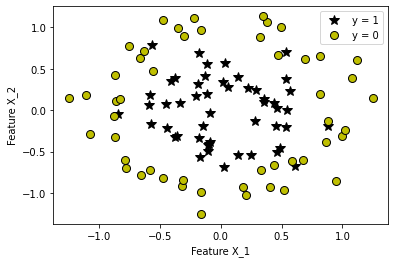

In [4]:
# Plot the data on a scatter plot using plotData function
fig, ax = plt.subplots()
plotData(X, y, ax)
# Set labels and legend for the plot
ax.set(xlabel="Feature X_1", ylabel="Feature X_2")
ax.legend(["y = 1", "y = 0"], loc="upper right")
plt.show()

As we can see, the decision boundary must have a shape similar to a circle, so that the positive samples are inside the circle while the negative ones are outside.  
Clearly, this decision boudary can't be fitted linearly with just 2 features. Usually, some feature engineering can be done to create new features for the dataset. Here we'll use the Feature Mapping technique to map the dataset from the original 2 features to quadratic features up to the 8th polynomial degree.

In [5]:
def mapFeature(X1, X2, degree=6):
    """Map the two input features to quadratic features.
    
    Return a new dataset with more features, comprising of:
    X1, X2, X1^2, X2^2, X1*X2, X1*X2^2,...

    Args:
        X1 (array_like): A vector of shape (m, 1) containing the first feature.
        
        X2 (array_like): A vector of shape (m, 1) containing the second feature. X1 and X2 must be the same size.
        
        degree (int, optional): The polynomial degree. Defaults to 6.
    """
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]
        
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))
            
    if X1.ndim > 0:
        return np.stack(out, axis=1)
    else:
        return np.array(out)

In [6]:
X = mapFeature(X[:, 0], X[:, 1], 8)
print("Shape of X:", X.shape)
print("Sample X[0]:", X[0])

Shape of X: (100, 45)
Sample X[0]: [ 1.00000000e+00 -1.72467631e-01 -5.58172063e-01  2.97450838e-02
  9.62666135e-02  3.11556052e-01 -5.13006415e-03 -1.66028748e-02
 -5.37333343e-02 -1.73901884e-01  8.84770012e-04  2.86345849e-03
  9.26726088e-03  2.99924460e-02  9.70671735e-02 -1.52594188e-04
 -4.93853903e-04 -1.59830253e-03 -5.17272612e-03 -1.67409455e-02
 -5.41801845e-02  2.63175582e-05  8.51738128e-05  2.75655452e-04
  8.92127822e-04  2.88727121e-03  9.34432808e-03  3.02418654e-02
 -4.53892692e-06 -1.46897257e-05 -4.75416428e-05 -1.53863172e-04
 -4.97960827e-04 -1.61159413e-03 -5.21574288e-03 -1.68801644e-02
  7.82817974e-07  2.53350220e-06  8.19939452e-06  2.65364168e-05
  8.58821242e-05  2.77947822e-04  8.99546820e-04  2.91128196e-03
  9.42203617e-03]


So the dataset has been mapped from 2 features to 45 features. Surely with this new training data, our model can fit quite well to the complex shape of the decision boundary. However, as mentioned before, one of the reasons for overfitting is using redundant features in the training process. Since we now have so many features, overfitting is unavoidable. Thus, we can apply the L2 regularization technique to reduce overfitting in the logistic regression model.

#### 4. L2 Regularization
Let's review the sigmoid function, loss function and gradient function in logistic regression:
- Sigmoid function: $$sigmoid(x)=\frac{1}{1+e^{-x}}$$
- Loss function:
$$
J(\theta)= \frac{1}{m} \sum_{i=1}^{m} \left[
    -y^{(i)} log \left(
        h_\theta(x^{(i)})
    \right)
    - (1-y^{(i)}) log \left(
        1-h_\theta(x^{(i)})
    \right)
\right]
$$
- Gradient function:
$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m}
\left(
    h_\theta(x^{(i)}) - y^{(i)}
\right)
x_{j}^{(i)}
$$

**So what is L2 regularization, and how is it applied to reduce overfitting?**  
L2 regularization is a technique to reduce overfitting in machine learning fields like regression or neural networks. In regression, it's called *Ridge Regression*, while in neural networks, it's also known as *Weight Decay*.  
This technique is actually just a new term added into the original loss function and gradient function:  
- Loss function:
$$
J(\theta)= \frac{1}{m} \sum_{i=1}^{m} \left[
    -y^{(i)} log \left(
        h_\theta(x^{(i)})
    \right)
    - (1-y^{(i)}) log \left(
        1-h_\theta(x^{(i)})
    \right)
\right] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_{j}^2
$$
- Gradient function:
$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m}
\left(
    h_\theta(x^{(i)}) - y^{(i)}
\right)
x_{j}^{(i)} \quad \text{for } j=0
$$

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \left[
    \frac{1}{m} \sum_{i=1}^{m}
    \left(
        h_\theta(x^{(i)}) - y^{(i)}
    \right)
    x_{j}^{(i)}
\right] + \frac{\lambda}{m} \theta_j \quad \text{for } j \geq 1
$$

$$ \text{where } \lambda \text{ is the hyperparameter to be tuned by a machine learning engineer.} $$

The basic idea of L2 regularization is to turn down the weights of features which can heavily affect the model performance while it's doing Gradient Descent. These features is the main reason that cause overfitting. What the added term in the above formulas means is after an iteration of Gradient Descent, the stronger a feature is, the more its weight gets reduced. However, the regularized weights don't disappear completely, they just approach very close to 0. And so with just a slight modification to the original loss function, L2 regularization helps balancing the effectiveness of the data features, which in turn help to reduce overfitting.  

An important thing to notice is that the regularization isn't applied on the weight value $\theta_0$ (as mentioned in the above Gradient function formula), because it's actually the bias value of the model, not the weight of a feature in the training data.  

Now let's create a logistic regression model applying the L2 regularization technique to perform classifcation on the toy dataset. We just need to make the loss function and gradient function, then the minimize() function from the scipy.optimize package can handle the gradient descent. For the Sigmoid function, we can use the scipy.special.expit() function since it's better optimized for some special cases.

In [7]:
def l2_loss(theta, X, y, lambda_):
    """Compute loss and gradient for logistic regression with L2 regularization.

    Args:
        theta (array_like): Logistic regression weights to be trained.
            A vector with shape (n,1), where n is the number of features including any intercept. If we have mapped our initial features into polynomial features, then n is the total number of polynomial features.
        
        X (array_like): The dataset features with shape (m,n), where m is the number of samples and n is the number of features after feature mapping.
        
        y (array_like): The data labels, a vector with shape (m,1).
        
        lambda_ (float): The regularization hyperparameter.
        
    Returns:
        J (float): The computed value for the regularized loss function.
        
        grad (array_like): A vector of shape (n,1) which is the gradients of the loss function with respect to theta, at the current values of theta.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training samples
    J = 0
    grad = np.zeros(theta.shape)
    epsilon = 1e-5 # To fix when the input of log function is too small that it becomes 0
    
    # Calculate sigmoid hypothesis
    h = expit(X @ theta)
    # Temporarily replace theta_0 with 0 to avoid regularization on the intercept/bias value
    theta_0 = theta[0]
    theta[0] = 0
    
    # Calculate loss value J and gradient
    regTerm = (lambda_ / (2.0 * m)) * np.sum(theta ** 2)
    J = (-1.0 * np.transpose(y) @ np.log(h + epsilon) - np.transpose(1.0 - y) @ np.log(1.0 - h + epsilon)) / m
    J += regTerm
    grad = (X.T @ (h - y)) / m + (lambda_ * theta) / m
    
    # Restore the original theta_0
    theta[0] = theta_0
    return J, grad

Now that we have a function to calculate the loss and gradient at each descent step. Let's optimize a model.

In [8]:
# A dataclass to save the trained model
@dataclass
class Model:
    cost: float
    theta: np.ndarray
    
    def predict(self, X) -> np.ndarray:
        p = expit(X @ self.theta.T) >= 0.5
        return p

In [11]:
def fit(X, y, lambda_, iterations, minimize_method="TNC"):
    """Fit a logistic regression model using the training data with L2 regularization.

    Args:
        X (array_like): The feature matrix of the training data.
        
        y (array_like): The label vector of the training data.
        
        lambda_ (float): The hyperparameter for tuning the L2 regularization, minimum is 0.
        
        iterations (int): Maximum number of iterations for the fitting process.
        
        minimize_method (str, optional): The method to fit the data. Defaults to "TNC". (See the documentations of scipy.optimize.minimize for available methods)
        
    Returns (Model):
        A trained model with these attributes:
        - cost (float): value of the loss function at the optimized theta
        - theta (array_like): the optimized theta
    """
    # Initialize fitting parameters
    initial_theta = np.zeros(X.shape[1])
    if lambda_ < 0:
        lambda_ = 0
        
    # Set options for the minimize function
    option = {
        "maxiter": iterations
    }
    
    res = optimize.minimize(l2_loss,
                            initial_theta,
                            (X, y, lambda_),
                            jac=True,
                            method=minimize_method,
                            options=option)
    
    # The "fun" property of OptimizeResult object returns:
    #   fun: the value of loss function at optimized theta
    #   x: the optimized theta
    return Model(res.fun, res.x)

3 models will be trained with 3 different $\lambda$ values to evaluate how L2 regularization can affect the predictions. The models will have the same training iterations, same training dataset and same minimization method.

In [12]:
models: list[Model] = [] # List of trained models
lambdas = [0.0, 1.0, 100.0]
for i in range(3):
    models.append(fit(X, y, lambdas[i], 100))

#### 5. Model evaluation
To visualize the predictions of the models, let's make a function to draw a decision boundary based on the optimized weight vector of each model.

In [13]:
def plotDecisionBoundary(plotData, theta, X, y, lambda_, ax):
    """Plot the data points of X into a new figure with the decision boundary defined by theta.
    
    The '*' symbols are positive samples and 'o' are negative samples.

    Args:
        plotData (func): A function reference for plotting the data.
        
        theta (array_like): Weight vector including the bias value for logistic regression, the shape is (n + 1, 1).
        
        X (array_like): The input feature data. The first column must be all 1's for the bias/intercept value.
        
        y (array_like): A vector of data labels, shape (m, 1).
    """
    # Plot data on scatter plot
    plotData(X[:, 1:3], y, ax)
    
    # Create the grid range, these are the test inputs to be used with the weights
    u = np.linspace(-1.5, 1.5, 50)
    v = np.linspace(-1.5, 1.5, 50)
    
    # Evaluate z = theta * x over the grid
    # Z are the output values predicted with test inputs from u, v and the trained weights
    z = np.zeros((u.size, v.size))
    for i, u_i in enumerate(u):
        for j, v_j in enumerate(v):
            # Create a test data point with 2 features
            temp = np.array([[u_i, v_j]]).reshape((1,2))
            # Use feature mapping on the data point to get the correct input dimension
            temp = mapFeature(temp[:, 0], temp[:, 1], 8)
            # Calculate the prediction for this data point
            z[i, j] = temp @ theta
            
    z = z.T # Important to transpose z before calling the contour function
    
    # Plot the contour line, which is the decision boundary at z = 0
    ax.contour(u, v, z, levels=[0], linewidths=2, colors='g')
    # Plot the color regions splitted by the boundary by drawing multiple contour line
    ax.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap="Greens", alpha=0.4)
    
    # Set labels, legend and title for the plot
    ax.set(xlabel="Feature X_1", ylabel="Feature X_2")
    ax.legend(["y = 1", "y = 0"], loc="upper right")
    ax.grid(False)
    ax.set_title("lambda = %0.2f" % lambda_)

Before checking the decision boundary, let's see the classification report of each model on the training data.

In [14]:
for i in range(3):
    print("Model", i + 1, "with lambda =", lambdas[i])
    print(classification_report(y, models[i].predict(X)))
    print()

Model 1 with lambda = 0.0
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        50
           1       0.98      0.96      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100


Model 2 with lambda = 1.0
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        50
           1       0.88      0.92      0.90        50

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100


Model 3 with lambda = 100.0
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        50
           1       0.71      1.00      0.83        50

    accuracy                           0.80       100
   macro avg       0.86      0.80      0.79   

- As we can see, the higher $\lambda$ is, the stronger the effect of L2 regularization becomes, although the accuracy of the model will decrease. A noteworthy thing is that based on the formula of the regularized loss function, when $\lambda = 0$, the regularization effect disappears, which is why the accuracy of model 1 is the highest. This is a sign of overfitting.
- On the contrary, the accuracy of model 3 is the lowest with only 80%. This is a sign of underfitting.
- Model 2 with $\lambda = 1$ seems to have a reasonable accuracy of 90%.

Now let's draw the decision boundary to see the effect of L2 regularization clearer.

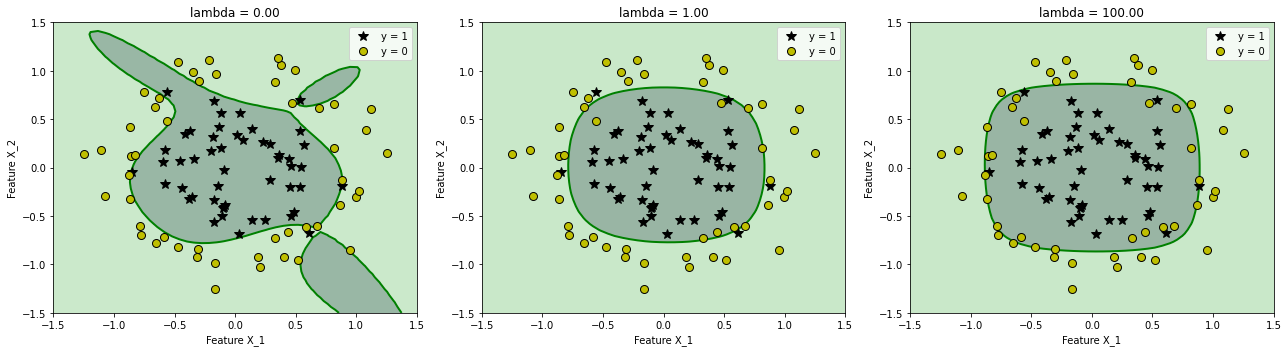

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(5 * 3 + 3, 5))
for i in range(3):
    plotDecisionBoundary(plotData, models[i].theta, X, y, lambdas[i], ax[i])
plt.tight_layout()
plt.show()

- From the figures above, we see that model 1 gives a very messy decision boundary as it tries to classify all positive samples. There are even empty regions which have been classified. So model 1 is truly overfitting because it doesn't use regularization.
- On the other hand, model 3 sets the $\lambda$ value too high so it becomes underfitting. Notice how the decision boundary also covers the negative samples in the same region as the positive ones.
- Finally, model 2 has a better boundary than the rest. The decision boundary doesn't try to cover every sample, instead it leaves out some samples straying too far away from the cluster. We can consider this model a good fit.

With the results above, we can conclude that model 2 is the best one out of the 3 models and applies L2 regularization with the hyperparameter $\lambda = 1$ pretty well.

#### 6. Conlusion
- L2 Regularization is one of the most popular technique to reduce overfitting and is widely used in regression and neural network algorithms. However, we need to be careful about the hyperparameter of this method. If $\lambda$ is too low, the model will still overfit, otherwise, if $\lambda$ is too high, the model can underfit. Usually, we start from a $\lambda$ value like 1 then start tuning the hyperparameter using techniques like Cross Validation, or a callback function to change the value between iterations.
- L2 Regularization is great for when we want to train a complex model with many features. This technique can help fitting even non-linear features, especially when we want to use all of the available features in the dataset.
- This technique isn't very flexible against outliers (as we can see from the above decision boundaries of model 1 and 3).
- Overall, L2 Regularization helps to improve the accuracy of a machine learning model in many cases and is widely applicable.

#### 7. References
- Bui Tien Len, Ho Chi Minh University of Science, Introduction to Machine Learning Course.
- Andrew Ng, Coursera, Machine Learning Online Course.